In [186]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import hilbert, butter, filtfilt, spectrogram
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import mne
from statsmodels.tsa.stattools import acf
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D
from stochastic_dynamics.models.ar import AR
from stochastic_dynamics.embedders import embed

In [187]:
# ============== PREPROCESSING ==============
from scipy import signal
from scipy.signal import hilbert

def load_eeg_data(time_path, signal_path):
    """Load EEG data from numpy files."""
    time = np.load(time_path)
    signal_data = np.load(signal_path)
    fs = 1 / np.mean(np.diff(time))
    return time, signal_data, fs

def bandpass_filter(x, Fs, low, high, order=4):
    wn = [low/(Fs/2), high/(Fs/2)]
    sos = signal.butter(order, wn, btype='bandpass', output='sos')
    return signal.sosfiltfilt(sos, x)

def envelope_normalize(x, fs, fband=(15, 30), env_lp_hz=5.0, eps=1e-6):
    b, a = signal.butter(4, np.array(fband)/(fs/2), btype='bandpass')
    x_bp = signal.filtfilt(b, a, x)
    z = hilbert(x_bp)
    A = np.abs(z)
    if env_lp_hz is not None:
        b_lp, a_lp = signal.butter(2, env_lp_hz/(fs/2), btype='low')
        A = signal.filtfilt(b_lp, a_lp, A)
    x_flat = x_bp / (A + eps)
    x_flat *= np.median(A)
    return x_flat, x_bp, A

def process_eeg_signal(raw_signal, Fs, 
                       notch_freq=60, notch_Q=30,
                       bandpass_low=0.5, bandpass_high=40,
                       fband=(1, 40), env_lp_hz=3.0):
    """Process EEG signal with notch filter, bandpass, and envelope normalization."""
    filtered = signal.filtfilt(*signal.iirnotch(notch_freq, notch_Q, Fs), raw_signal)
    x = np.asarray(filtered).ravel()
    xs_raw = bandpass_filter(x, Fs, low=bandpass_low, high=bandpass_high)
    xs, _, _ = envelope_normalize(xs_raw, Fs, fband=fband, env_lp_hz=env_lp_hz)
    return xs, xs_raw

def fit_ar_model(xs, Fs, p=4, train_frac=0.9, refresh_every=5):
    X, y = AR.lag_matrix(xs, p)
    ntr = int(train_frac * len(y))
    X_tr, y_tr = X[:ntr], y[:ntr]
    w = AR.fit(X_tr, y_tr)
    N_te = len(y) - ntr
    t0 = p + ntr
    true_test = xs[t0 : t0 + N_te]
    yhat_ctrl = AR.hybrid_predict(xs, w, p, start_idx=t0, n_steps=N_te, refresh_every=refresh_every)
    full_pred = AR.hybrid_predict(xs, w, p, start_idx=p, n_steps=len(xs)-p, refresh_every=refresh_every)
    xs_pred_full = np.concatenate([xs[:p], full_pred])
    mse, mae, corr = AR.metrics(true_test, yhat_ctrl)
    return {
        'w': w, 'p': p, 'ntr': ntr, 'y': y, 'true_test': true_test,
        'yhat_ctrl': yhat_ctrl, 'xs_pred_full': xs_pred_full, 't0': t0,
        'mse': mse, 'mae': mae, 'corr': corr, 'refresh_every': refresh_every
    }

def embed3(s, tau):
    """Create 3D delay embedding"""
    return np.column_stack([s[2*tau:], s[tau:-tau], s[:-2*tau]])

print("AR class imported.")

AR class imported.


In [188]:
# Load data using the simpler function
# time_proc, raw_signal, fs_proc = load_eeg_data(
#     '/Users/novak/Documents/UTSW/erfan/eegeeg_time.npy',
#     '/Users/novak/Documents/UTSW/erfan/eegeeg_signal.npy'
# )

time_proc, raw_signal, fs_proc = load_eeg_data(
    '/Users/novak/Documents/UTSW/erfan/eeg_time_sec3.npy',
    '/Users/novak/Documents/UTSW/erfan/eeg_signal_sec3.npy'
)

# Process the signal
preprocessed, xs_raw = process_eeg_signal(raw_signal, fs_proc)

snippet_sec = 25  # seconds to display
start_idx = 8000  # start index to avoid edge effects
N_snip = int(snippet_sec * fs_proc)

filtered = preprocessed[start_idx:start_idx+N_snip]
t_snip = time_proc[start_idx:start_idx+N_snip]
x_snip = filtered

print(f"Loaded EEG: {len(raw_signal)} samples at {fs_proc:.2f} Hz")
print(f"Duration: {time_proc[-1] - time_proc[0]:.2f} seconds")
print(f"Snippet contains: {snippet_sec} seconds")

Loaded EEG: 1440000 samples at 400.00 Hz
Duration: 3600.00 seconds
Snippet contains: 25 seconds


In [189]:
# ============== GLOBAL PLOT STYLE ==============
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "lines.linewidth": 1.8,
    "lines.markersize": 5,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

color_main = "black"
color_alt = "darkred"

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    """Unified styling for axes"""
    if title: ax.set_title(title, pad=10)
    if xlabel: ax.set_xlabel(xlabel, labelpad=5)
    if ylabel: ax.set_ylabel(ylabel, labelpad=5)
    ax.grid(alpha=0.0, linestyle="--", linewidth=0.7)
    if add_legend: 
        ax.legend(frameon=False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(1.0)

print("Plot style configured.")

Plot style configured.


In [190]:
plot_sec = 5
plot_n_snip = int(plot_sec * fs_proc)

plot_x_snip = preprocessed[start_idx:start_idx+plot_n_snip]
plot_t_snip = time_proc[start_idx:start_idx+plot_n_snip]



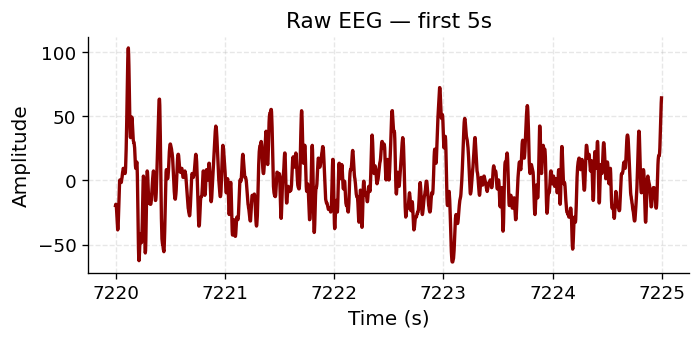

In [191]:
# ============== PLOT: Raw Time Series ==============
DATA_TYPE = "EEG"  # Options: "EEG" (scalp) or "LFP" (intracranial)

# Get raw signal snippet (same time window as filtered)
raw_x_snip = raw_signal[start_idx:start_idx+plot_n_snip]

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(plot_t_snip, raw_x_snip, lw=2.0, color=color_alt)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title(f"Raw {DATA_TYPE} — first {plot_sec}s")
ax.grid(True, ls='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
 

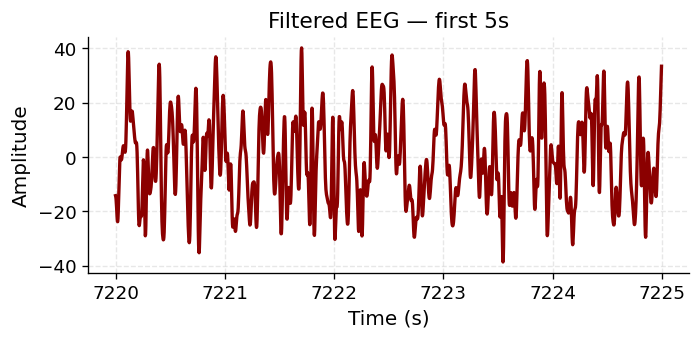

In [192]:
# ============== PLOT (a): Filtered Time Series ==============
# Data type label (change based on your data)
DATA_TYPE = "EEG"  # Options: "EEG" (scalp) or "LFP" (intracranial)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(plot_t_snip, plot_x_snip, lw=2.0, color=color_alt)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title(f"Filtered {DATA_TYPE} — first {plot_sec}s")
ax.grid(True, ls='--', alpha=0.3)
ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
 

/var/folders/w2/4bn86c516gl31kymqxtwhnmw0000gn/T/ipykernel_57837/645307803.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0,50])


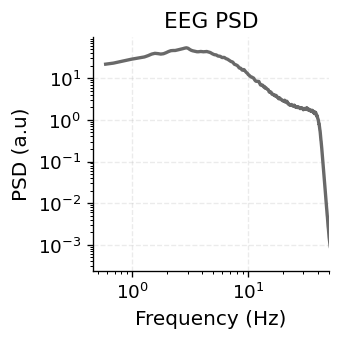

In [194]:
# ============== PLOT (c): PSD ==============
# PSD frequency range depends on data type:
#   EEG (scalp): 0.5-50 Hz (higher is mostly artifact)
#   LFP (intracranial): 0.5-200 Hz (can see gamma/ripples)

# PSD_FMAX = 50.0 if DATA_TYPE == "EEG" else 200.0

# Compute PSD using Welch method
psd, freqs = mne.time_frequency.psd_array_welch(
    raw_signal[None, :],
    sfreq=fs_proc,
    fmin=0.5, fmax=100,
    n_fft=4096,
    n_overlap=2048,
    average='mean',
    verbose=False
)
psd = psd[0]

# Smooth PSD
psd_smooth = gaussian_filter1d(psd, sigma=1)

# Plot PSD
fig, ax = plt.subplots(figsize=(3, 3))
ax.loglog(freqs, psd_smooth, 'dimgray', lw=2)
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim([0,50])
ax.set_ylabel("PSD (a.u)")
ax.set_title(f"{DATA_TYPE} PSD")
ax.grid(True, ls="--", alpha=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

Best p by MSE: p=6


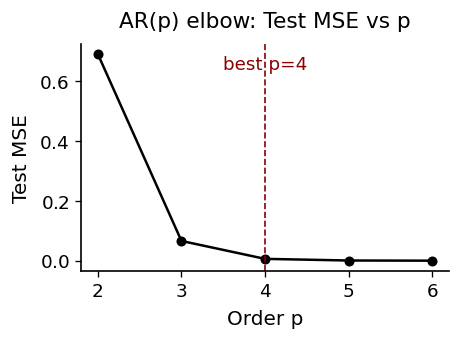

In [195]:
# ============== AR MODEL FITTING ==============
# Sweep AR orders for elbow plot
p_list = list(range(2, 7))
mse_te_list = []
params_by_p = {}

# filtered = raw_signal
for p in p_list:
    X, y = AR.lag_matrix(filtered, p)
    ntr = int(0.9 * len(y))
    X_tr, y_tr = X[:ntr], y[:ntr]
    X_te, y_te = X[ntr:], y[ntr:]
    w = AR.fit(X_tr, y_tr)
    yhat_te = AR.predict_from_params(X_te, w)
    mse_te, _, _ = AR.metrics(y_te, yhat_te)
    mse_te_list.append(mse_te)
    params_by_p[p] = w

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]
print(f"Best p by MSE: p={best_p_by_mse}")
best_p_by_mse = 4

def plot_mse_elbow(p_list, mse_list, best_p, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(p_list, mse_list, marker='o', color=color_main, lw=1.5, ms=5)
    ax.axvline(best_p, linestyle='--', color=color_alt, linewidth=1)
    ax.text(best_p, ax.get_ylim()[1]*0.95, f"best p={best_p}", ha='center', va='top', color=color_alt, fontsize=11)
    sf = ScalarFormatter(useMathText=True)
    sf.set_powerlimits((-3, 3))
    ax.yaxis.set_major_formatter(sf)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax.yaxis.get_offset_text().set_size(10)
    prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
    plt.tight_layout()
    plt.show()

plot_mse_elbow(p_list, mse_te_list, best_p_by_mse)

In [196]:
ar_results = fit_ar_model(filtered, fs_proc, p=best_p_by_mse, train_frac=0.8, refresh_every=5)

w = ar_results['w']
p_use = ar_results['p']
ntr = ar_results['ntr']
y = ar_results['y']
true_test = ar_results['true_test']
yhat_ctrl = ar_results['yhat_ctrl']
xs_pred_full = ar_results['xs_pred_full']
REFRESH_EVERY = ar_results['refresh_every']

print(f"AR({p_use}): MSE={ar_results['mse']:.6f}, corr={ar_results['corr']:.3f}")

AR(4): MSE=3.488139, corr=0.993


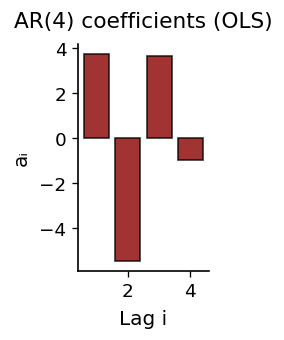

In [197]:
def plot_ar_coefficients(w, p, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(2, 3))
    ax.bar(np.arange(1, p+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.8)
    prettify(ax, title=f"AR({p}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
    plt.tight_layout()
    plt.show()

plot_ar_coefficients(w, p_use)

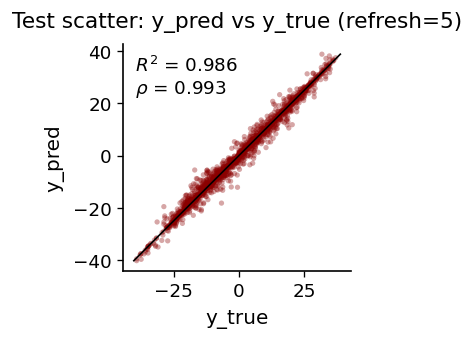

In [198]:
def plot_scatter(y_true, y_pred, refresh, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
    vmin, vmax = min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred))
    ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / (ss_tot + 1e-12)
    ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
            transform=ax.transAxes, ha='left', va='top', fontsize=11,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
    ax.set_aspect('equal', adjustable='box')
    prettify(ax, title=f"Test scatter: y_pred vs y_true (refresh={refresh})", xlabel="y_true", ylabel="y_pred")
    plt.tight_layout()
    plt.show()

plot_scatter(y[ntr:], yhat_ctrl, REFRESH_EVERY)

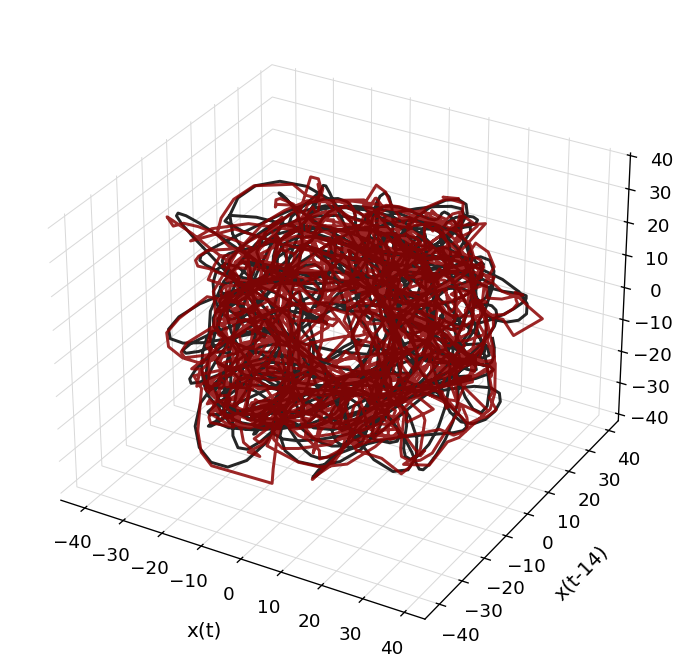

In [199]:
def plot_state_space(
    X3_true, X3_pred, p, tau, refresh,
    color_true="black", color_pred="darkred"
):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2],
            color=color_true, alpha=0.85)
    ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2],
            color=color_pred, alpha=0.85)

    ax.set_xlabel("x(t)", labelpad=10)
    ax.set_ylabel(f"x(t-{tau})", labelpad=10)
    ax.set_zlabel(f"x(t-{2*tau})", labelpad=10)

    # --- Make the 3D grid lighter (like your second plot) ---
    ax.grid(True)

    grid_color = (0.85, 0.85, 0.85, 1.0)  # light gray
    grid_lw = 0.6
    grid_alpha = 0.35

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis._axinfo["grid"]["color"] = grid_color
        axis._axinfo["grid"]["linewidth"] = grid_lw
        axis._axinfo["grid"]["linestyle"] = "-"
        axis._axinfo["grid"]["alpha"] = grid_alpha

    # Optional: make the panes white / less “boxed”
    ax.xaxis.set_pane_color((1, 1, 1, 1))
    ax.yaxis.set_pane_color((1, 1, 1, 1))
    ax.zaxis.set_pane_color((1, 1, 1, 1))

    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.show()

tau = 14
hy = yhat_ctrl - np.mean(yhat_ctrl)
hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)

X3_true = embed(true_test, 3, tau)
X3_hyb = embed(hy, 3, tau)

plot_state_space(X3_true, X3_hyb, p_use, tau, REFRESH_EVERY)

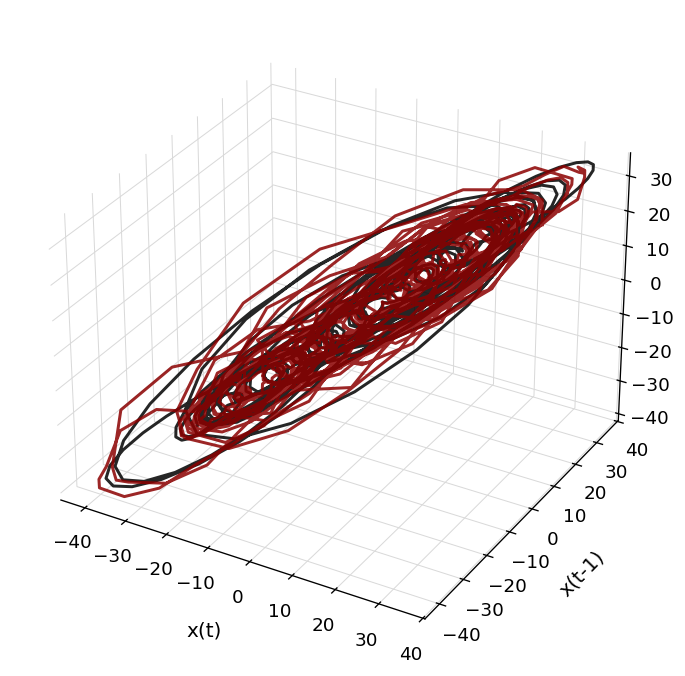

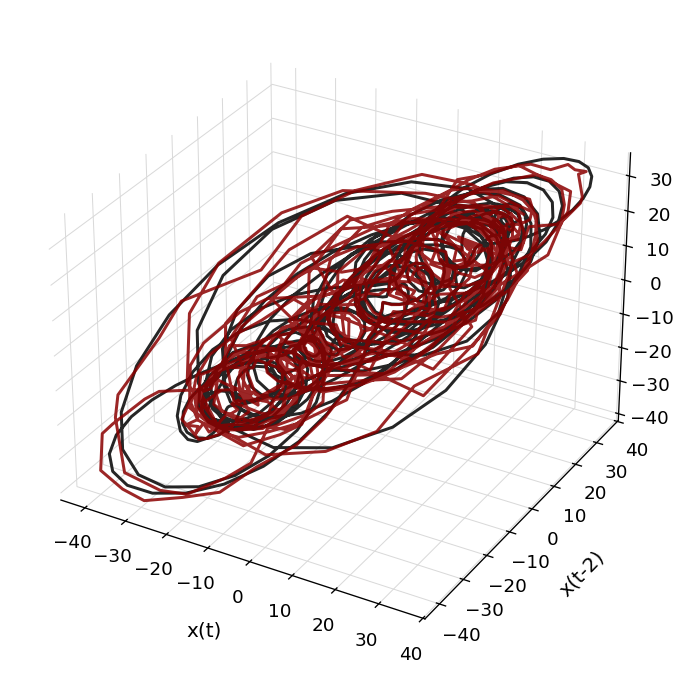

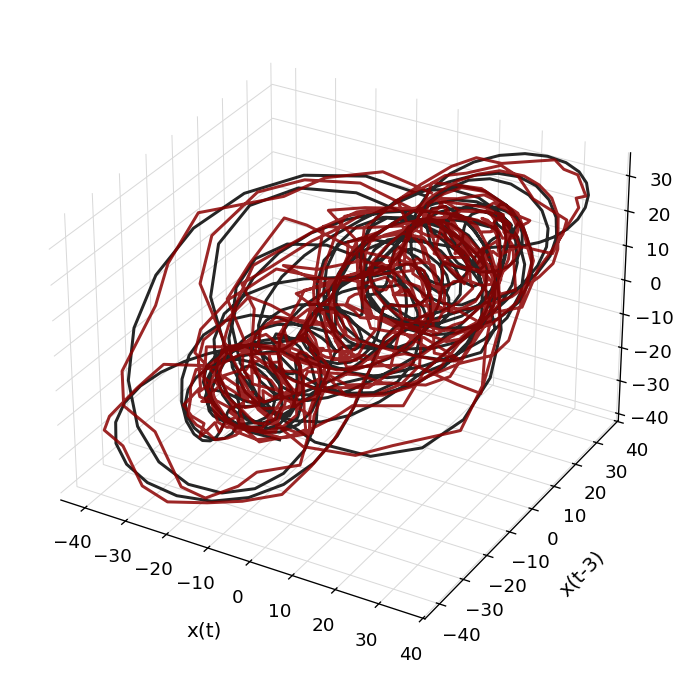

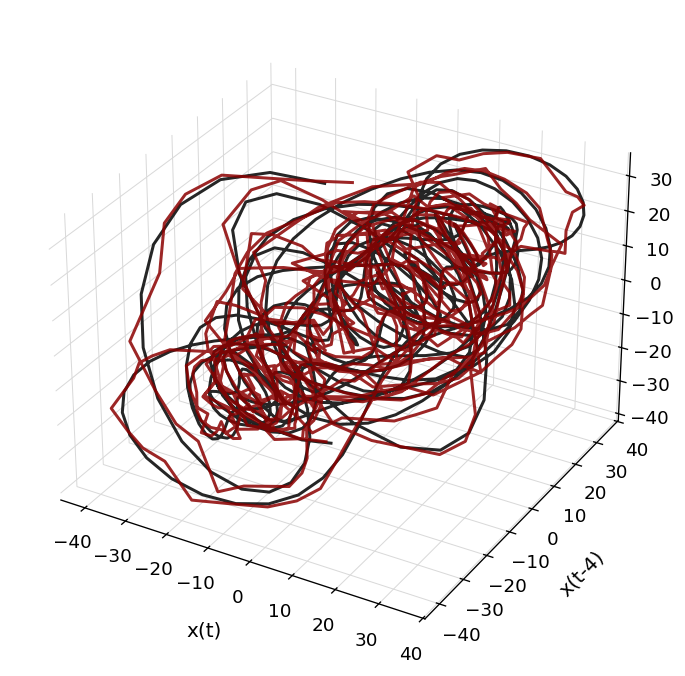

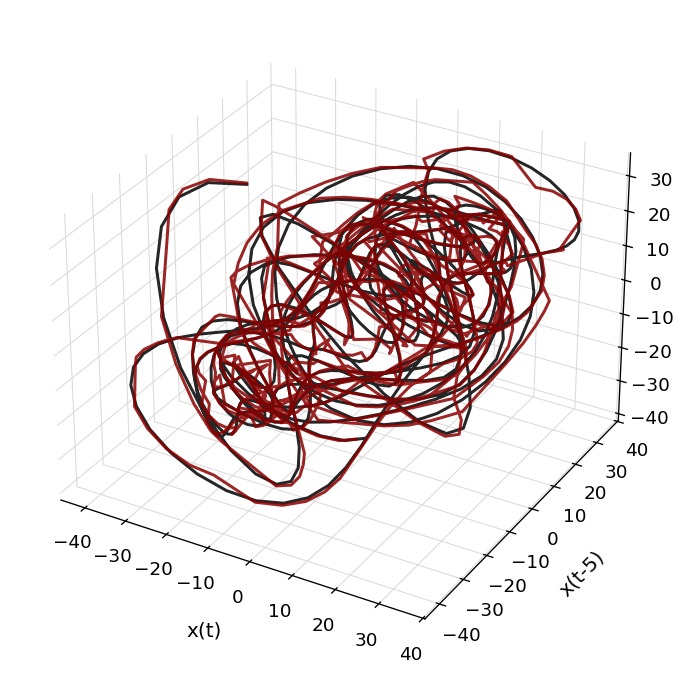

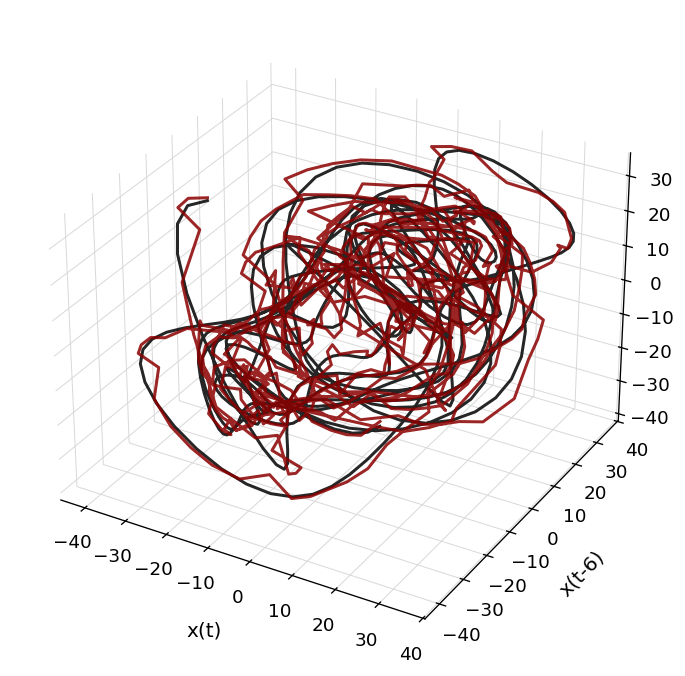

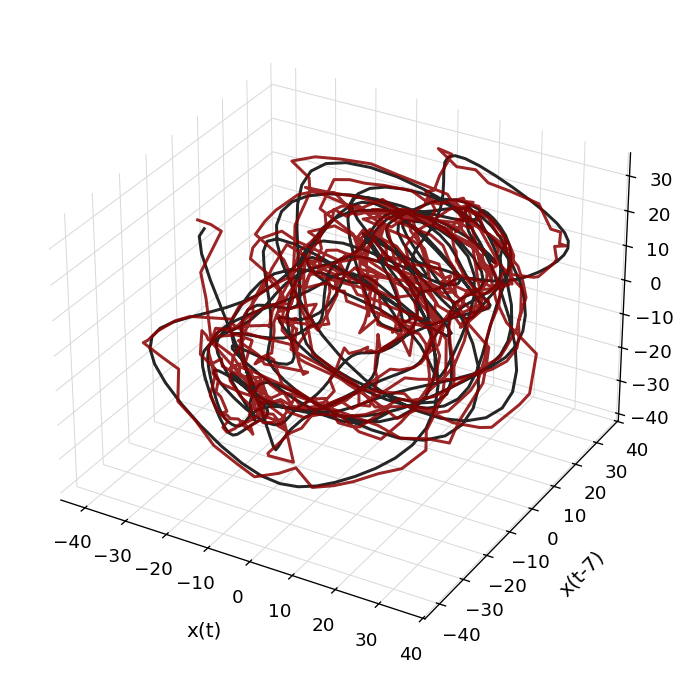

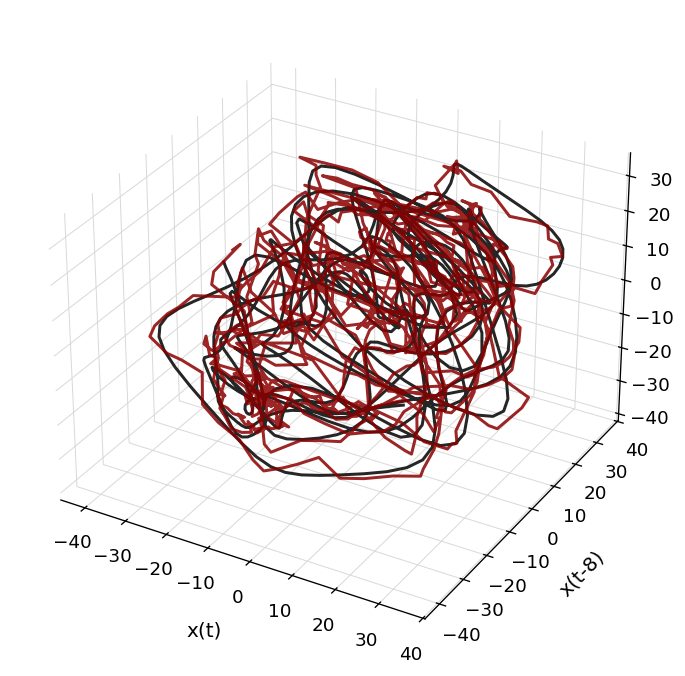

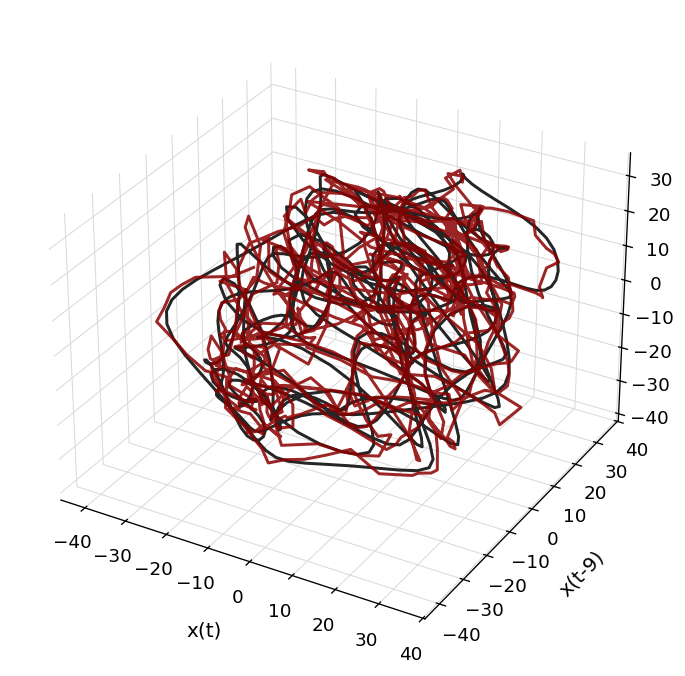

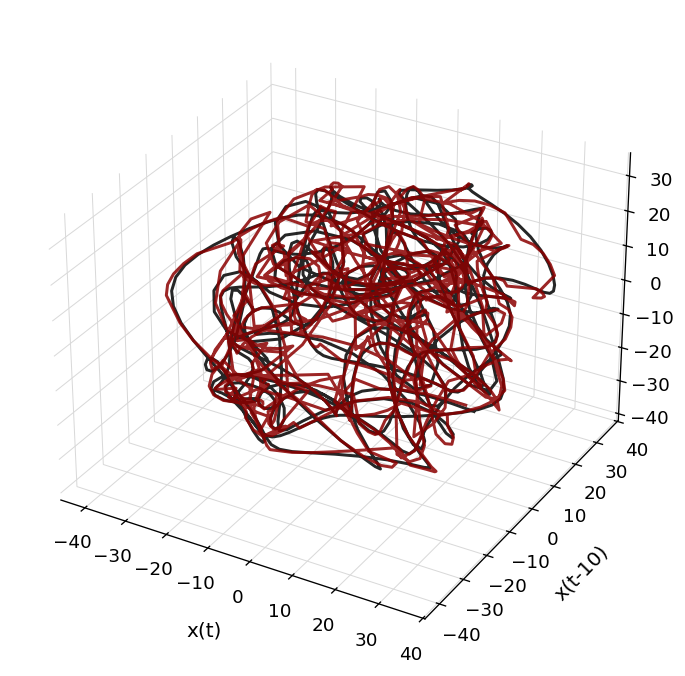

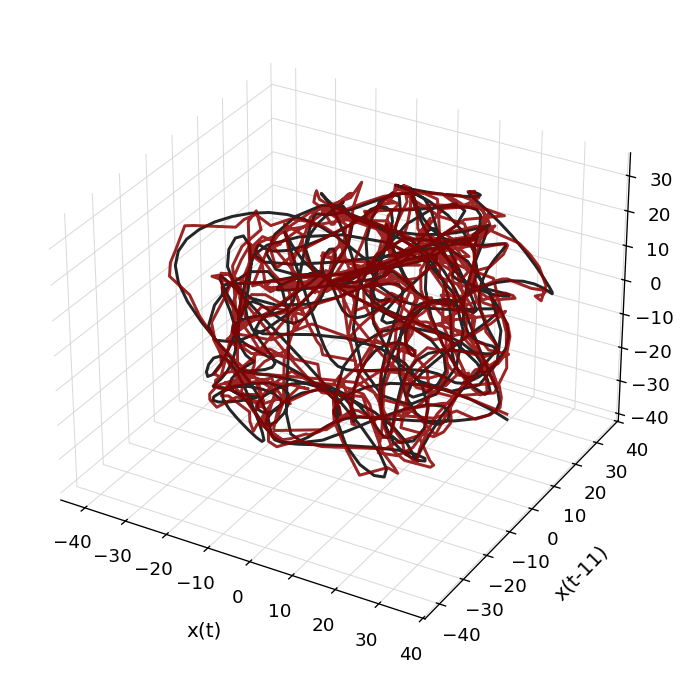

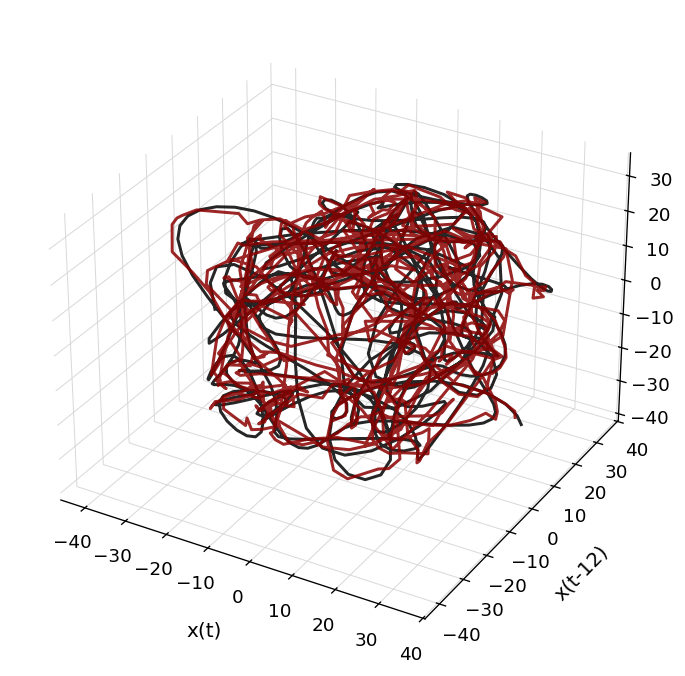

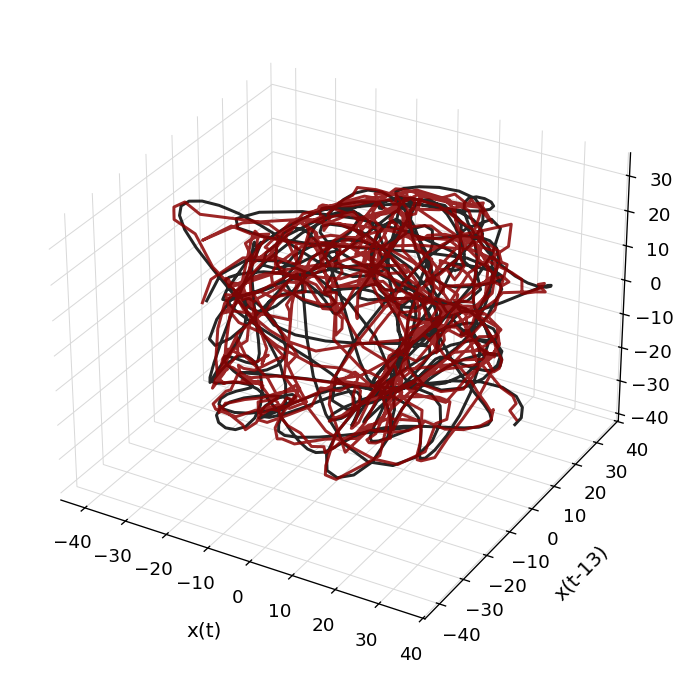

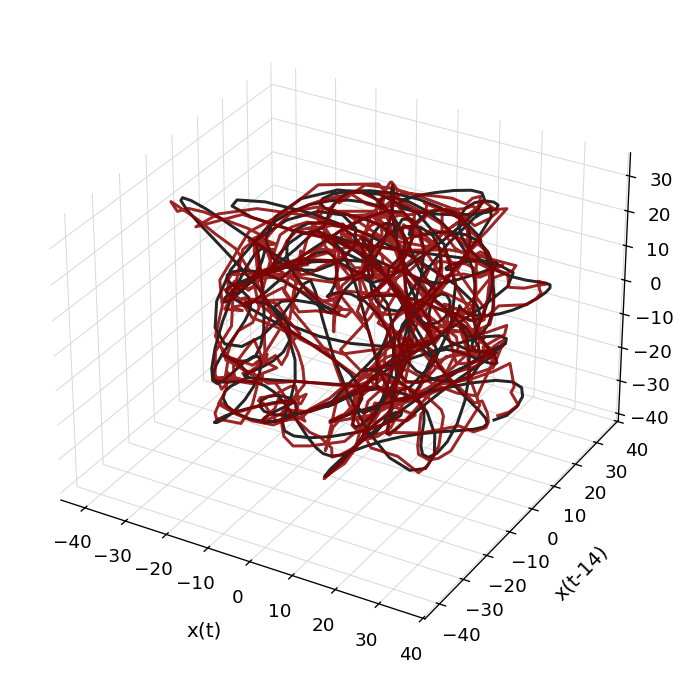

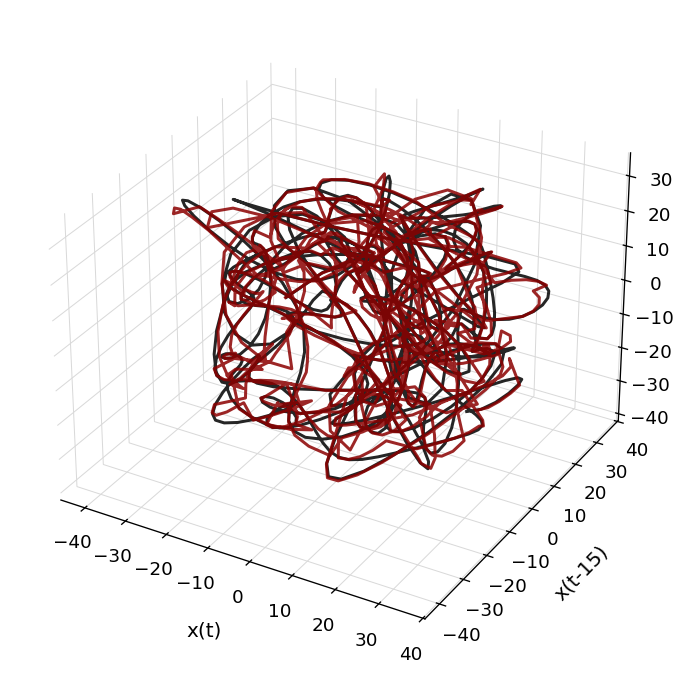

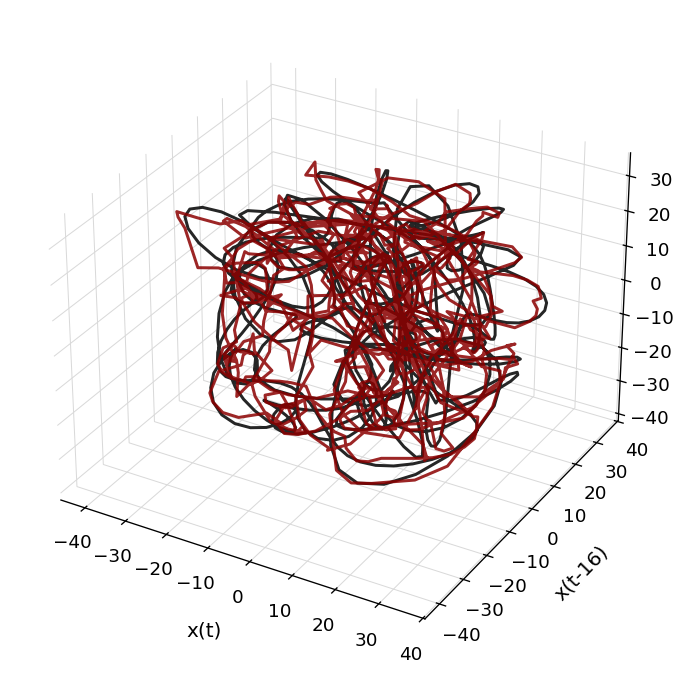

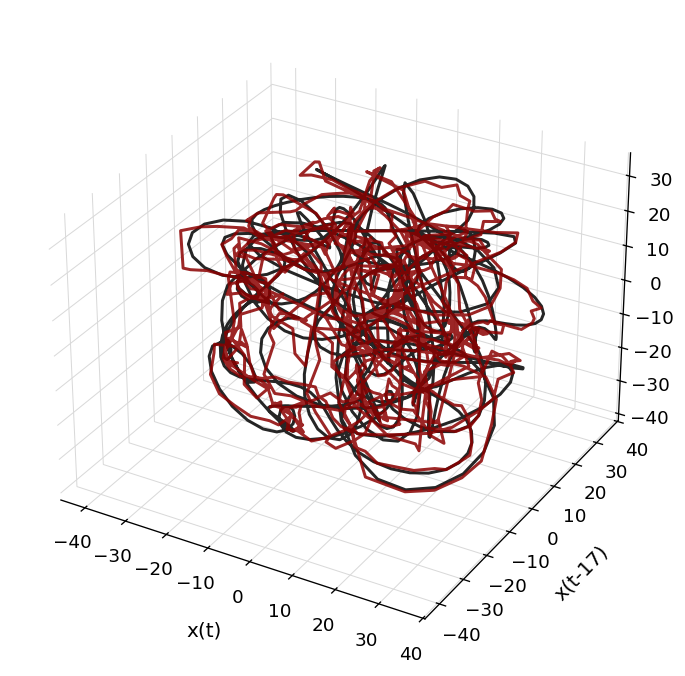

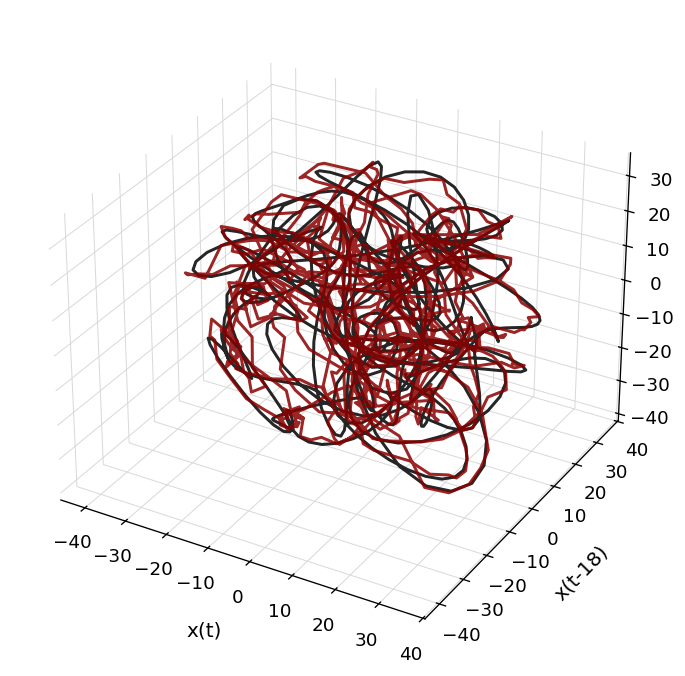

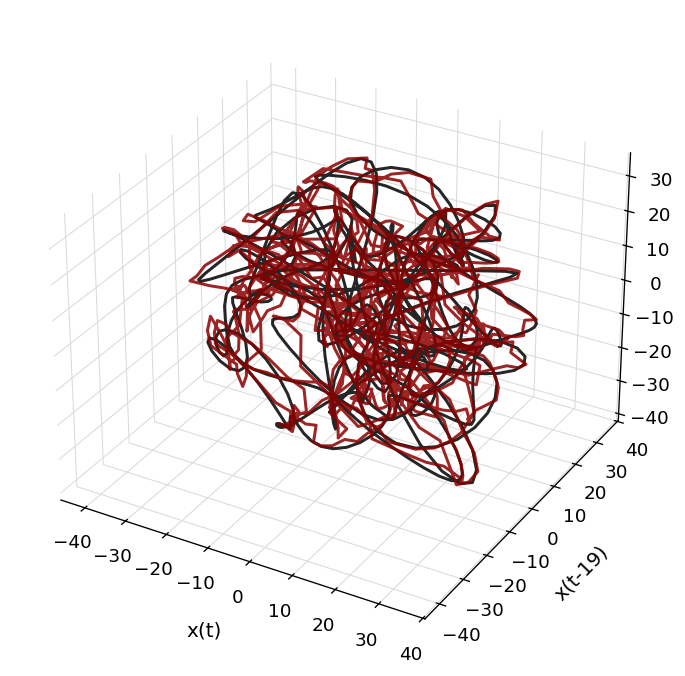

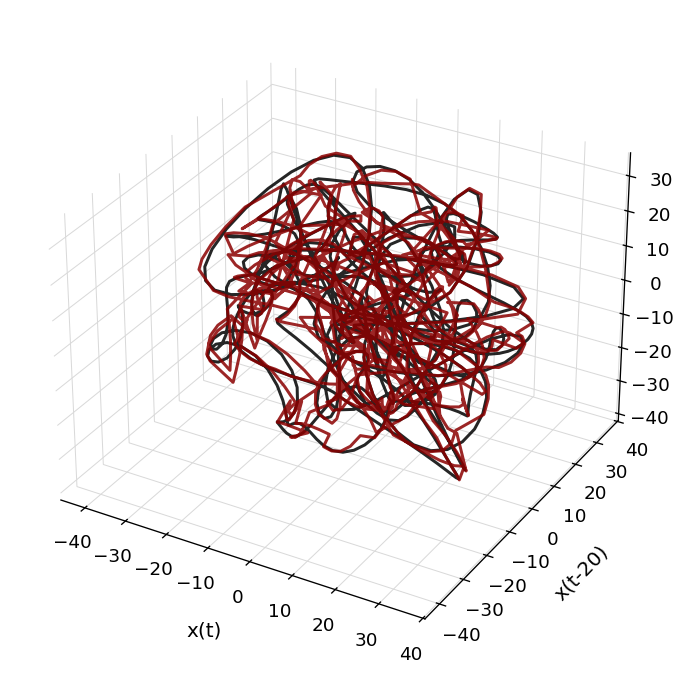

In [200]:
# Loop through different tau values
for tau in range(1, 21, 1):  # 5, 10, 15, ..., 50
    hy = yhat_ctrl - np.mean(yhat_ctrl)
    hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)
    
    X3_true = embed(true_test, 3, tau)
    X3_hyb = embed(hy, 3, tau)
    
    plot_state_space(X3_true[:900], X3_hyb[:900], p_use, tau, REFRESH_EVERY)